# Task 2: Implementing Quantum Variational Circuits
by Beom Joon Baek

In [ ]:
!pip install pennylane

In [3]:
!pip install torch

In [4]:
import pennylane as qml
import numpy as np
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt

For this task, we will be using Pennylane's default qubit simulator to simulate four 4-qubit quantum states. We will also be using Pytorch to run both the backpropagation and the classical ADAM optimizer. 

In [52]:
# Prepare the Device
dev = qml.device('default.qubit', wires = 4)

## 1. Preparation

As I understand the task, there are total 16 qubits as part of the initial state (4 random state x 4 qubits). We can store the entire initial configurations in the `initial_state` tensor. We will represent the random initial qubit as a coordinate on block sphere parameterized by three rotational angles.


In [53]:
# Initialize Variables
num_inputs = 4
num_qubits = 4
 
initial_state = np.random.normal(0, np.pi/2, (num_inputs, num_qubits, 3))
initial_state = Variable(torch.tensor(initial_state), requires_grad=False)

We can check the `initial_state` and its dimensions.

In [54]:
print("Dimensions: " + str(initial_state.size()))
print(initial_state[0])

Dimensions: torch.Size([4, 4, 3])
tensor([[ 0.9477, -0.4696,  1.6892],
        [-3.2567, -0.8193, -0.9658],
        [-0.9722,  0.6656, -0.7870],
        [-1.3500,  1.4013, -0.1158]], dtype=torch.float64)


Every layer in the variational circuit will be a Strongly Entangling Layer, as shown here: ![Image of StronglyEntanglingLayers](https://pennylane.readthedocs.io/en/stable/_images/layer_sec.png)

Each layer of `weights` tensor has twelve parameters (three per each qubit representing its rotations). 


In [95]:
num_layers = 5

weights = np.random.normal(0, np.pi/2, (num_layers, num_qubits, 3))
weights = Variable(torch.tensor(weights), requires_grad=True) 

Finally, we know what the expected outputs are. We will store them in `expected_outputs` tensor. Note that the ground state is represented as -1 here.

In [85]:
expected_outputs = np.array(
    [[-1, -1, 1, 1],
     [-1, 1, -1, 1],
     [1, -1, 1, -1],
     [1, 1, -1, -1]
     ])

expected_outputs = Variable(torch.tensor(expected_outputs), requires_grad=False)

## 2. Circuit Design

We implement the variational circuit for Strongly Entangling Layer. 

In [96]:
def layer(W):
    for i in range(num_qubits):
      qml.Rot(W[i, 0], W[i, 1], W[i, 2], wires=i)

    for j in range(num_qubits):
      qml.CNOT(wires=[j, (j+1) % 4])

@qml.qnode(dev, interface="torch")
def circuit(weights, input_index):

    init = initial_state[input_index]

    # Initialize input state
    for i in range(num_qubits):
      qml.Rot(init[i, 0], init[i, 1], init[i, 2], wires=i)

    for i in range(num_layers):
        layer(weights[i])

    return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

A sanity check to make sure that our circuit looks as expected. Note that we will pass on indicies to refer to the input states (ex. index=0 means that random state 1 is provided, meaning that it should return state $|0011\rangle$).

In [97]:
circuit(weights, 0)
print(circuit.draw())

 0: ──Rot(0.948, -0.47, 1.69)─────Rot(0.38, -0.503, -1.28)──╭C───────────────────────────────────────────────────────────╭X──Rot(0.218, -0.238, -1.17)──╭C──────────────────────────────────────────────────────────╭X──Rot(1.78, -0.0952, 0.325)──╭C──────────────────────────────────────────────────────────╭X──Rot(1.74, -0.669, 0.481)──╭C─────────────────────────────────────────────────────────────╭X──Rot(-1.77, -1.09, 1.36)──╭C──────────╭X──┤ ⟨Z⟩ 
 1: ──Rot(-3.26, -0.819, -0.966)──Rot(-3.5, 0.546, 1.9)─────╰X──╭C───Rot(-1.15, -2.21, 0.357)────────────────────────────│──────────────────────────────╰X──╭C───Rot(-1.24, 2.03, -0.513)───────────────────────────│──────────────────────────────╰X──╭C───Rot(-0.588, -1.51, -1.01)──────────────────────────│─────────────────────────────╰X──╭C───Rot(1.49, 0.0666, -1.02)──────────────────────────────│────────────────────────────╰X──╭C──────│───┤ ⟨Z⟩ 
 2: ──Rot(-0.972, 0.666, -0.787)──Rot(-0.59, -0.4, -0.197)──────╰X──╭C─────────────────────────Rot(0.228

## 3. Optimization

Our goal is to make sure that depending on the random state index, the actual output matches as closely as the expected output. As such, we can define the cost function as:

$$ C = \Sigma_{i=1}^{4}(\hat{y_i}-y_i)^2 $$

where $\hat{y}$ is the expected qubit state (ex. $|0011\rangle$for random state 1) and $y$ is the measured qubit state along Z axis.

In [98]:
def cost(weights, input_index):
    output = circuit(weights, input_index)
    expected_output = expected_outputs[input_index]

    cost = 0
    for i in range(num_qubits):
      cost += torch.square(expected_output[i] - output[i])
    
    return cost

Now we can run the optimization.

In [99]:
# set up the optimizer
opt = torch.optim.Adam([weights], lr=0.005)
steps = 2500

best_cost = cost(weights, 0)

loss_log = []

# optimization begins
for n in range(steps):
    indicies = list(range(num_inputs))
    np.random.shuffle(indicies)

    loss_sum = 0
    opt.zero_grad()

    for index in indicies: 
      loss = cost(weights, index)
      loss_sum += loss

    loss_sum.backward()
    opt.step()

    if loss < best_cost:
        best_cost = loss
        best_weight = weights

    if n % 10 == 0:
      loss_log.append(loss_sum / num_inputs)

    if n % 100 == 99:
        print("Cost after {} steps is {:.4f}".format(n + 1, best_cost))

Cost after 100 steps is 1.0893
Cost after 200 steps is 0.3143
Cost after 300 steps is 0.2285
Cost after 400 steps is 0.2185
Cost after 500 steps is 0.2185
Cost after 600 steps is 0.2185
Cost after 700 steps is 0.2185
Cost after 800 steps is 0.2185
Cost after 900 steps is 0.2185
Cost after 1000 steps is 0.2185
Cost after 1100 steps is 0.1971
Cost after 1200 steps is 0.1585
Cost after 1300 steps is 0.1228
Cost after 1400 steps is 0.1013
Cost after 1500 steps is 0.0936
Cost after 1600 steps is 0.0927
Cost after 1700 steps is 0.0927
Cost after 1800 steps is 0.0927
Cost after 1900 steps is 0.0927
Cost after 2000 steps is 0.0863
Cost after 2100 steps is 0.0842
Cost after 2200 steps is 0.0842
Cost after 2300 steps is 0.0842
Cost after 2400 steps is 0.0842
Cost after 2500 steps is 0.0842


## 4. Results & Analysis

This visualizes the loss throughout layer numbers.

In [100]:
loss_log_dict[num_layers]  = loss_log

In [101]:
loss_log_dict.keys()

dict_keys([3, 2, 1, 4, 5])

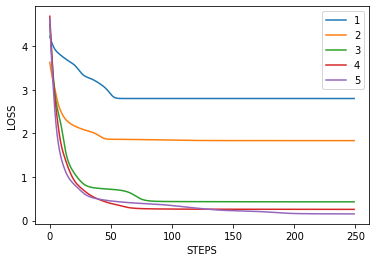

In [103]:
log_loss_list = sorted(list(loss_log_dict.items()), key=lambda a: a[0])
for num_layer, loss in log_loss_list:
    plt.plot(loss, label=str(num_layer))

plt.ylabel('LOSS')
plt.xlabel('STEPS')
plt.legend()
plt.show()

This shows that increasing number of layers results lower loss. However, after the third layer, it seems to be stuck at a plateau. Since this is using a simualtor, in real life quantum computers, the extra benefit of #4 and #5 layer might not be that prominent.

We can see how close the results are to the expected value.

In [104]:
for i in range(num_inputs):
  expected_output = expected_outputs[i]
  result = circuit(best_weight, i)

  print("Expected: ")
  print(expected_output)

  print("Actual: ")
  print(result)

Expected: 
tensor([-1, -1,  1,  1])
Actual: 
tensor([-0.7635, -0.7739,  0.7556,  0.7581], dtype=torch.float64,
       grad_fn=<CatBackward>)
Expected: 
tensor([-1,  1, -1,  1])
Actual: 
tensor([-0.8710,  0.7691, -0.9202,  0.8917], dtype=torch.float64,
       grad_fn=<CatBackward>)
Expected: 
tensor([ 1, -1,  1, -1])
Actual: 
tensor([ 0.8564, -0.8172,  0.8713, -0.8564], dtype=torch.float64,
       grad_fn=<CatBackward>)
Expected: 
tensor([ 1,  1, -1, -1])
Actual: 
tensor([ 0.7838,  0.7546, -0.7911, -0.7654], dtype=torch.float64,
       grad_fn=<CatBackward>)


Although not an exact match, it shows a general good match with the expected value.

In [105]:
best_weight

tensor([[[ 0.8510, -0.6865, -1.3884],
         [-4.5748,  0.2905,  2.9350],
         [-1.9173, -1.0476,  0.8131],
         [-1.3261,  1.1436, -1.3967]],

        [[-0.8215, -1.2220, -1.2098],
         [-1.2060, -1.2387, -0.2153],
         [-0.4225, -1.1852,  1.2077],
         [-4.1541,  0.2387,  0.4177]],

        [[ 3.7078, -0.9911, -2.6410],
         [-1.3939,  0.7263, -1.5258],
         [ 3.4288, -0.0272,  2.0382],
         [ 3.6883, -1.0564, -0.0051]],

        [[ 2.8894, -1.4568,  0.1506],
         [-1.5198, -1.0758, -1.5523],
         [-1.0499,  1.5663,  0.3458],
         [ 1.2186,  1.2244,  0.4463]],

        [[-1.6487, -0.7580,  1.3602],
         [ 3.2616,  1.2156, -1.0174],
         [-0.4031, -1.7757, -2.5718],
         [ 3.2261, -1.7989,  2.8644]]], dtype=torch.float64,
       requires_grad=True)

Let's provide a different state to see what happens.

In [107]:
# Initialize Variables
num_inputs = 4
num_qubits = 4
 
new_state = np.random.normal(0, np.pi/2, (num_inputs, num_qubits, 3))
new_state = Variable(torch.tensor(new_state), requires_grad=False)

In [108]:
@qml.qnode(dev, interface="torch")
def circuit2(weights, input_index):

    init = new_state[input_index]

    # Initialize input state
    for i in range(num_qubits):
      qml.Rot(init[i, 0], init[i, 1], init[i, 2], wires=i)

    for i in range(num_layers):
        layer(weights[i])

    return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

In [109]:
for i in range(num_inputs):
  result = circuit2(best_weight, i)
  print(result)

tensor([-0.0811,  0.2195, -0.2084,  0.0991], dtype=torch.float64,
       grad_fn=<CatBackward>)
tensor([ 0.3176,  0.1439, -0.2667, -0.2511], dtype=torch.float64,
       grad_fn=<CatBackward>)
tensor([ 0.0070,  0.0491, -0.6412, -0.1111], dtype=torch.float64,
       grad_fn=<CatBackward>)
tensor([-0.0783, -0.3329,  0.2595,  0.5059], dtype=torch.float64,
       grad_fn=<CatBackward>)


Seems like there is no major correlation between the input and the output for this weight, although it warrants a closer look.